# AT82.08 Computer Vision Final Exam 2024

`Change the filename by inserting your student ID before submitting the file.`

# Question 1: Object Detection (10 points)
We've explored the evolution of the `R-CNN family`, encompassing `R-CNN`, `Fast R-CNN`, and `Faster R-CNN`. Analyze the key differences between these models, identifying their respective limitations and the specific challenges they were developed to overcome.

r-cnn generates region proposals then applies CNN. it is slow and computationally expensive it is a 2-stage framework

fast r-cnn uses single neural network  it is faster but still have limited by pre defined anchor boxes. it eliminates region proposal generation

faster r-cnn generates proposals in parallel with feature extraction it is more flexible and better in performance it has region proposal network (RPN)

# Question 2: GAN


## Question 2.1 (35 points)

In week 11 lecture, we learnt and implemented GAN in which the generator and discriminator were constructed with only linear layers, and trained using MNIST dataset. We observed that the quality of genereted images was not good, and needed further improvement.

[DCGAN](https://arxiv.org/pdf/1511.06434.pdf) is an extension of the GAN, in which it explicitly uses `convolutional` and `convTransposed` layers in the discriminator and generator, respectively. In other words, DCGAN replaces linear layers in GAN with `conv.` layers in the discriminator, and `convTranspose` layers in the generator.

Use the following guideline to `Implement DCGAN model`:
- at least `4 conv. layers` in the `discrimimator`.
- at least `4 convTranspose layers` in the `generator`.
- latent vector `z = 100` and being sample from `normal` distribution
- Use `batchnorm` in both the generator and the discriminator.
- Use `ReLU` activation in generator for all layers except for the output, which uses `Tanh`.
- Use `LeakyReLU` activation in the discriminator for all layers.


Train the model
- `MNIST` dataset
- `25` epochs
- batch size of `128`

**`Report the following`**
- Plot both generator and discriminator `losses`.
- Show the visualization of the generated images of `every 5 epochs`

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

# device = "mps" if torch.cuda.is_available else "cpu"
# device


'cuda'

In [15]:
import os
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [16]:
NUM_EPOCHS = 25
BATCH_SIZE = 128
glr = 2e-4
dlr= 2e-4
latent_dim = 100
img_dim = (1, 28, 28)
save_model = True
logging_interval = 200

In [17]:
class Generator(nn.Module):
  def __init__(self, latent_dim = 100, img_dim=(1,28,28)):
    super(Generator, self).__init__()
    self.latent_dim = latent_dim
    self.img_dim = img_dim

    self.model = nn.Sequential(
        nn.ConvTranspose2d(latent_dim, 128, kernel_size=3, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),

        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),

        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(True),

        nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, bias=False),
        nn.Tanh()
    )

  def forward(self, z):
    img = self.model(z.view(-1, 100, 1, 1))
    return img

In [18]:
class Discriminator(nn.Module):
  def __init__(self, img_dim=(1,28,28)):
    super(Discriminator, self).__init__()
    self.img_dim = img_dim

    self.model = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(128, 1, kernel_size=3, stride=2, padding=1, bias=False),
        nn.Sigmoid()
    )

  def forward(self, img):
    validity = self.model(img)
    return validity.view(-1, 1).squeeze(1)

In [19]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
generator = Generator()
discriminator = Discriminator()

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

/home/st125051/work/CV2024/.venv/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [22]:
criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(generator.parameters(), lr=glr)
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=dlr)


In [ ]:
for epoch in range(NUM_EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        optimizerD.zero_grad()
        real_outputs = discriminator(images)
        real_loss = criterion(real_outputs, torch.ones_like(real_outputs).to(device))

        noise = torch.randn(BATCH_SIZE, 100).to(device)
        fake_images = generator(noise)
        fake_outputs = discriminator(fake_images.detach())
        fake_loss = criterion(fake_outputs, torch.zeros_like(fake_outputs).to(device))
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizerD.step()

        optimizerG.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = criterion(fake_outputs, torch.ones_like(fake_outputs).to(device))
        g_loss.backward()
        optimizerG.step()

    print(f'Epoch {epoch+1}, D loss: {d_loss.item():.4f}, G loss: {g_loss.item():.4f}')

    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            noise = torch.randn(64, 100).to(device)
            fake_images = generator(noise)
            plt.figure(figsize=(8, 8))
            plt.axis("off")
            plt.title("Generated Images")
            plt.imshow(np.transpose(make_grid(fake_images[:64],
                                            padding=2, normalize=True),
                                            (1, 2, 0)))
            plt.show()

In [ ]:
gen = Generator(latent_dim, img_dim)
dis = Discriminator(img_dim)
num_params = sum(p.numel() for p in gen.parameters())

In [ ]:
num_trainable_params = sum(p.numel() for p in gen.parameters() if p.requires_grad)
print(f'Total num. of parameters: {num_params}')
print(f'Total num. of Trainable parameters: {num_trainable_params}')

In [ ]:
adversarial_loss = torch.nn.BCELoss()
optimizer_G = torch.optim.Adam(gen.parameters(), lr=glr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(dis.parameters(), lr=dlr, betas=(0.5, 0.999))

In [ ]:
log_dict = {'train_generator_loss_per_batch': [],
              'train_discriminator_loss_per_batch': [],
              'train_discriminator_real_acc_per_batch': [],
              'train_discriminator_fake_acc_per_batch': [],
              'images_from_noise_per_epoch': []}

In [19]:
fixed_z = torch.randn(64, latent_dim, device=device)

In [6]:
start_time = time.time()
for epoch in range(NUM_EPOCHS):

  gen.train()
  dis.train()
  for batch_idx, (features, _) in enumerate(train_loader):

    batch_size = features.size(0)

    # real images
    real_images = features.to(device)
    real_labels = torch.ones(batch_size, device=device) # real label = 1

    # generated (fake) images
    z = torch.randn(batch_size, latent_dim, device=device)  # format NCHW
    fake_images = gen(z)
    fake_labels = torch.zeros(batch_size, device=device) # fake label = 0
    flipped_fake_labels = real_labels 
    flipped_fake_labels.to(device)

    # --------------------------
    # Train Discriminator
    # --------------------------

    optimizer_D.zero_grad()

    discr_pred_real = dis(real_images).view(-1) 
    real_loss = adversarial_loss(discr_pred_real, real_labels)

    discr_pred_fake = dis(fake_images.detach()).view(-1)
    fake_loss = adversarial_loss(discr_pred_fake, fake_labels)

    discr_loss = 0.5*(real_loss + fake_loss)

    discr_loss.backward()
    optimizer_D.step()

    # --------------------------
    # Train Generator
    # --------------------------

    optimizer_G.zero_grad()

    discr_pred_fake = dis(fake_images).view(-1)
    gener_loss = adversarial_loss(discr_pred_fake, flipped_fake_labels)
    gener_loss.backward()

    optimizer_G.step()

    # --------------------------
    # Logging
    # --------------------------
    log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
    log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())

    predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
    predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
    acc_real = (predicted_labels_real == real_labels).float().mean()*100.
    acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
    log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
    log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())

    if not batch_idx % logging_interval:
      print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f'
              % (epoch+1, NUM_EPOCHS, batch_idx,
                len(train_loader), gener_loss.item(), discr_loss.item()))

  with torch.no_grad():
    fake_images = gen(fixed_z).detach().cpu()
    log_dict['images_from_noise_per_epoch'].append(make_grid(fake_images,
                                                              padding=2,
                                                              normalize=True))

  plt.figure(figsize=(10, 5))
  plt.plot(log_dict['train_generator_loss_per_batch'], label='Generator Loss')
  plt.plot(log_dict['train_discriminator_loss_per_batch'], label='Discriminator Loss')
  plt.legend()
  plt.show()

  if (epoch+1) % 5 == 0:
    plt.figure(figsize=(8, 8))
                        
    plt.axis("off")
    plt.title("Generated Images from Noise")
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
    plt.show()

  print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

NameError: name 'time' is not defined

In [ ]:
if save_model:
    torch.save({
            'model_state_dict': gen.state_dict(),
            'optimizer_state_dict': optimizer_G.state_dict()
            }, 'ganGen_mnist.pt')

    torch.save({
            'model_state_dict': dis.state_dict(),
            'optimizer_state_dict': optimizer_D.state_dict()
            }, 'ganDis_mnist.pt')

In [ ]:
losses_list=(log_dict['train_discriminator_loss_per_batch'],
            log_dict['train_generator_loss_per_batch'])
custom_labels_list=(' -- Discriminator', ' -- Generator')
averaging_iterations = 100

for i,_ in enumerate(losses_list):
    if not len(losses_list[i]) == len(losses_list[0]):
        raise ValueError('All loss tensors need to have the same number of elements.')

if custom_labels_list is None:
    custom_labels_list = [str(i) for i,_ in enumerate(custom_labels_list)]

iter_per_epoch = len(losses_list[0]) // NUM_EPOCHS

plt.figure()
ax1 = plt.subplot(1, 1, 1)

for i, minibatch_loss_tensor in enumerate(losses_list):
    ax1.plot(range(len(minibatch_loss_tensor)),
              (minibatch_loss_tensor),
              label=f'Minibatch Loss{custom_labels_list[i]}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    ax1.plot(np.convolve(minibatch_loss_tensor,
                          np.ones(averaging_iterations,)/averaging_iterations,
                          mode='valid'),
              color='black')

if len(losses_list[0]) < 1000:
    num_losses = len(losses_list[0]) // 2
else:
    num_losses = 1000
maxes = [np.max(losses_list[i][num_losses:]) for i,_ in enumerate(losses_list)]
ax1.set_ylim([0, np.max(maxes)*1.5])
ax1.legend()

###################
# Set second x-axis
ax2 = ax1.twiny()
newlabel = list(range(NUM_EPOCHS+1))

newpos = [e*iter_per_epoch for e in newlabel]

ax2.set_xticks(newpos[::10])
ax2.set_xticklabels(newlabel[::10])

ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 45))
ax2.set_xlabel('Epochs')
ax2.set_xlim(ax1.get_xlim())
###################

plt.tight_layout()

plt.savefig('losses.png')
plt.show()

## Question 2.2 (10 points)

Recall from our GAN lab session, we implemented and trained GAN on MNIST dataset.

**Qualitative Comparison**: Conduct a comparative analysis of the image outputs generated by `GAN` and `DCGAN` models at the `25th` epoch. Determine which model produces better quality images and discuss the underlying reasons for its superior performance.

*Your answer here*

# Question 3: Mean Shift (25 points)
As previously discussed, Mean Shift segmentation leverages Euclidean distance to cluster pixels in a feature space defined by pixel attributes. While we have utilized RGB color information as features, incorporating additional spatial information may enhance segmentation performance. By augmenting the feature space to include pixel coordinates (X,Y), we can apply Mean Shift to this expanded representation.


#### Implement Mean Shift segmentation using the `XYRGB` space of the given image (`q3-labrador-kmean.jpg`).
- How does the performance compare to using only the RGB color space?
- Show the center of clusters, how many clusters are there?

In [ ]:
# Your code here

In [1]:
import numpy as np
import cv2
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt

In [2]:
image = cv2.imread('q3-labrador-kmean.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [3]:
height, width, _ = image.shape

In [4]:
x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
X = np.column_stack((x_coords.ravel(), y_coords.ravel(), image.reshape(-1, 3)))

In [5]:
mean_shift = MeanShift(bandwidth=5, max_iter=10) # keeping this less to run faster
mean_shift.fit(X)

MeanShift(bandwidth=5, max_iter=10)

In [7]:
labels = mean_shift.labels_
cluster_centers = mean_shift.cluster_centers_
n_clusters = len(np.unique(labels))

In [8]:
segmented_image = labels.reshape(height, width)

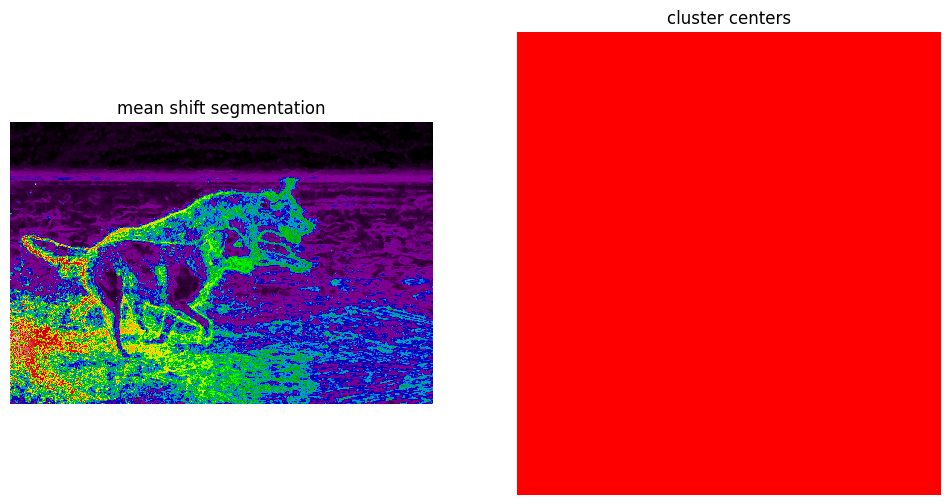

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('mean shift segmentation')
plt.imshow(segmented_image, cmap='nipy_spectral')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('cluster centers')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=100)
plt.xlim(0, width)
plt.ylim(height, 0)
plt.axis('off')

plt.show()

In [10]:
# Example of turning nx3 (RGB) array of image pixels to nx5 (XYRGB) array of image pixels

In [11]:
# Show the center of clusters, how many clusters are there?

**Expected result**

You may get a slight different result.

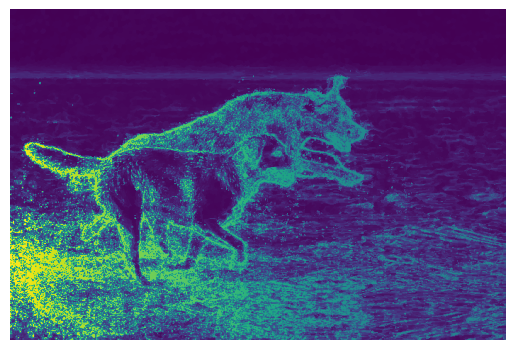

In [12]:
plt.axis('off')
plt.imshow(segmented_image)
plt.show()

# Question 4: 3D Deep Learning

## Question 4.1: (10 points)
We have discussed five 3D reprensentations used in 3D Deep learning for tasks like classification and segmentation.

- ### What are those 5 representations ? Briefly describe attributes of each representation.
- ### Analyze the advantages and disadvantages of each representation when applied to deep learning models


point clouds:

collection of points in 3f space using x y z coordinates 

point clouds are unordered and represent surface of objects

efficient for capturing detailed shapes 

can be challenging for neural networks due to their irregular structure

=======

voxel grids:

3d grids where space is divided into small cubes

each voxel can be filled or empty, based on material availibility

structured 

memory-intensive for high-resolution

=========

mesh:

composed of vertices edges and faces to for 3d objects

capture detailed geometry 

can be complex because of irregular structure

======

sign distance field:

good for shapes

scalar field where each point in space represent shortest distance to surface of object

positive values are outside object

negative values are inside object

smooth representations

=========

depth maps:

2d images each pixel represent distance from camera to nearest surface point

easy to capture 

useful for object detection

lose some 3d information

## Question 4.2: (10 points)

`PointNet` is a pioneering 3D deep learning model capable of handling point cloud data for classification and segmentation tasks. Unlike traditional image data, point clouds lack a regular grid structure and the order of points is arbitrary.

Discuss the strategies employed by PointNet to overcome these challenges and highlight its significant contributions to the field of 3D deep learning.


*Your answer here!*

---
pointNet overcomes point cloud challenges with

it handles point cloud data effectively

it have symmetry functions

improved robustness with spatial transformations

path for advance 3d deep learning models in todays world

===========

symmetry functions ensure order invariance using max pooling

spatial transformations aligns data to a canonical orientation

point-wise feature extracts local features using MLP

global feature extraction captures global features with max pooling